# Colab setup

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Projetos/ZAAI
sys.path.append('/content/drive/My Drive/Projetos/ZAAI/')
%pip install -r requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Projetos/ZAAI
  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-ju6i183v
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-ju6i183v
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 55166d3227c91554653397068cba13c02589ea4d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# import TiDE_tuning

# Load Libraries and set global variables

In [29]:
%load_ext autoreload
%autoreload 2
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.pipeline import Pipeline
from chronos import ChronosPipeline
from darts.models import TiDEModel, TSMixerModel
from darts import TimeSeries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import random
import torch
import utils

TIME_COL = "Date"
TARGET = "Weekly_Sales"
RES_TARGET = "residuals"
STATIC_COV = ["Store", "Dept", "Type", "Size"]
DYNAMIC_COV_FILL_0 = ["IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
DYNAMIC_COV_FILL_INTERPOLATE = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FREQ = "W-FRI"

SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

FORECAST_HORIZON = 10 # number of weeks to forecast
TOP_STORES = 500 # number of top stores to forecast

CHRONOS_ARCHITECTURE = ("amazon/chronos-t5-tiny", "cpu")
# CHRONOS_ARCHITECTURE = ("amazon/chronos-t5-large","cuda")
# CHRONOS_ARCHITECTURE = ("amazon/chronos-t5-tiny","cuda")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Datasets

In [30]:
# load data and exogenous features
df = pd.read_csv('data/train.csv')
store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

# create unique id
df["unique_id"] = df['Store'].astype(str)+'-'+df['Dept'].astype(str)

print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df

Distinct number of time series: 3331


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,unique_id
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1-1
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1-1
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,1-1
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,1-1
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,45-98
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,45-98
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,45-98
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,45-98


## Pre-process dataset

In [31]:
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df.loc[:, TIME_COL] = pd.to_datetime(df[TIME_COL])

df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET]) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
                "medium")) # make size a categorical variable

top10_stores = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(10)
top_stores = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(TOP_STORES)
df = df[df['unique_id'].isin(top_stores['unique_id'])]

print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df

Distinct number of time series: 500


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,unique_id
143,1,2,2010-02-05,50605.27,0,A,medium,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,1-2
144,1,2,2010-02-12,44682.74,1,A,medium,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,1-2
145,1,2,2010-02-19,47928.89,0,A,medium,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,1-2
146,1,2,2010-02-26,44292.87,0,A,medium,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,1-2
147,1,2,2010-03-05,48397.98,0,A,medium,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,1-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421285,45,95,2012-09-28,49380.11,0,B,medium,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,45-95
421286,45,95,2012-10-05,50241.01,0,B,medium,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,45-95
421287,45,95,2012-10-12,49334.77,0,B,medium,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,45-95
421288,45,95,2012-10-19,48434.97,0,B,medium,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,45-95


# Training with the whole dataset until the start of the window, and forecast for each window

In [32]:
window1_start=pd.to_datetime('2012-01-20')
window1=(window1_start,window1_start + pd.Timedelta(weeks=FORECAST_HORIZON))
test1 = df[(df[TIME_COL] <= window1[1])]

window2_start = pd.to_datetime('2012-03-16')
window2=(window2_start,window2_start + pd.Timedelta(weeks=FORECAST_HORIZON))
test2 = df[(df[TIME_COL] <= window2[1])]

window3_start = pd.to_datetime('2012-05-25')
window3=(window3_start,window3_start + pd.Timedelta(weeks=FORECAST_HORIZON))
test3 = df[(df[TIME_COL] <= window3[1])]

window4_start = pd.to_datetime('2012-08-03')
window4=(window4_start,window4_start + pd.Timedelta(weeks=FORECAST_HORIZON))
test4 = df[(df[TIME_COL] <= window4[1])]

#window = (window1[0],window1[1])
#window = (window2[0],window2[1])
#window = (window3[0],window3[1])
window = (window4[0],window4[1])

windows = [window1, window2, window3, window4]

## Split Data

In [ ]:
train = df[(df["Date"] <= window[0])]
test = df[(df["Date"] > window[0]) & (df["Date"] <= window[1])]
df = df[(df[TIME_COL] <= window[1])]

train_darts = TimeSeries.from_group_dataframe(
    df=train,
    group_cols=STATIC_COV,
    time_col=TIME_COL,
    value_cols=TARGET,
    freq=FREQ,
    fill_missing_dates=True,
    fillna_value=0)

print(f"Weeks for training: {len(train[TIME_COL].unique())} from {min(train[TIME_COL]).date()} to {max(train[TIME_COL]).date()}")
print(f"Weeks for testing: {len(test[TIME_COL].unique())} from {min(test[TIME_COL]).date()} to {max(test[TIME_COL]).date()}")

Weeks for training: 131 from 2010-02-05 to 2012-08-03
Weeks for testing: 10 from 2012-08-10 to 2012-10-12


# TSMixer

In [ ]:
tsmixer_forecast_window1 = pd.read_csv('data/tsmixer_forecast_2012-01-20_2012-03-30.csv')
tsmixer_forecast_window1['Date'] = pd.to_datetime(tsmixer_forecast_window1['Date'])

tsmixer_forecast_window2 = pd.read_csv('data/tsmixer_forecast_2012-03-16_2012-05-25.csv')
tsmixer_forecast_window2['Date'] = pd.to_datetime(tsmixer_forecast_window2['Date'])

tsmixer_forecast_window3 = pd.read_csv('data/tsmixer_forecast_2012-05-25_2012-08-03.csv')
tsmixer_forecast_window3['Date'] = pd.to_datetime(tsmixer_forecast_window3['Date'])

tsmixer_forecast_window4 = pd.read_csv('data/tsmixer_forecast_2012-08-03_2012-10-12.csv')
tsmixer_forecast_window4['Date'] = pd.to_datetime(tsmixer_forecast_window4['Date'])

tsmixer_forecast = [tsmixer_forecast_window1, tsmixer_forecast_window2, tsmixer_forecast_window3, tsmixer_forecast_window4]


In [ ]:
# dynamic_covariates = utils.create_dynamic_covariates(train_darts,df,FORECAST_HORIZON)

In [ ]:
'''
# scale covariates
dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

# scale data and transform static covariates
data_transformed = PIPELINE.fit_transform(train_darts)

TSMixer_params = {
    "input_chunk_length": 16,
    "output_chunk_length": FORECAST_HORIZON,
    "hidden_size": 16,
    "ff_size": 4,
    "num_blocks": 1,
    "activation": "ELU",
    "dropout": 0.3,
    "normalize_before": True,
    "batch_size": 32,
    "n_epochs": 10,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 0.001},
    "use_reversible_instance_norm": False,
}

tsmixer = TSMixerModel(**TSMixer_params)
tsmixer.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
pred = PIPELINE.inverse_transform(tsmixer.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))
tsmixer_forecast = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])
tsmixer_forecast.to_csv('data/tsmixer_forecast' + str(window[0].date().strftime('%Y-%m-%d')) + '_' + str(
        window[1].date().strftime('%Y-%m-%d')) + '.csv', index=False)
tsmixer_forecast
'''

'\n# scale covariates\ndynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)\n\n# scale data and transform static covariates\ndata_transformed = PIPELINE.fit_transform(train_darts)\n\nTSMixer_params = {\n    "input_chunk_length": 16,\n    "output_chunk_length": FORECAST_HORIZON,\n    "hidden_size": 16,\n    "ff_size": 4,\n    "num_blocks": 1,\n    "activation": "ELU",\n    "dropout": 0.3,\n    "normalize_before": True,\n    "batch_size": 32,\n    "n_epochs": 10,\n    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),\n    "random_state": 42,\n    "use_static_covariates": True,\n    "optimizer_kwargs": {"lr": 0.001},\n    "use_reversible_instance_norm": False,\n}\n\ntsmixer = TSMixerModel(**TSMixer_params)\ntsmixer.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)\npred = PIPELINE.inverse_transform(tsmixer.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples

# TiDE

In [ ]:
tide_forecast_window1 = pd.read_csv('data/tide_forecast_2012-01-20_2012-03-30.csv')
tide_forecast_window1['Date'] = pd.to_datetime(tide_forecast_window1['Date'])

tide_forecast_window2 = pd.read_csv('data/tide_forecast_2012-03-16_2012-05-25.csv')
tide_forecast_window2['Date'] = pd.to_datetime(tide_forecast_window2['Date'])

tide_forecast_window3 = pd.read_csv('data/tide_forecast_2012-05-25_2012-08-03.csv')
tide_forecast_window3['Date'] = pd.to_datetime(tide_forecast_window3['Date'])

tide_forecast_window4 = pd.read_csv('data/tide_forecast_2012-08-03_2012-10-12.csv')
tide_forecast_window4['Date'] = pd.to_datetime(tide_forecast_window4['Date'])

tide_forecast = [tide_forecast_window1, tide_forecast_window2, tide_forecast_window3, tide_forecast_window4]

In [ ]:
# dynamic_covariates = utils.create_dynamic_covariates(train_darts,df,FORECAST_HORIZON)

In [ ]:
'''
# scale covariates
dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

# scale data and transform static covariates
data_transformed = PIPELINE.fit_transform(train_darts)

TiDE_params = {
    "input_chunk_length": len(train[TIME_COL].unique()) - FORECAST_HORIZON, # number of weeks to lookback
    "output_chunk_length": FORECAST_HORIZON, # number of weeks to forecast
    "num_encoder_layers": 2,
    "num_decoder_layers": 2,
    "decoder_output_dim": 1,
    "hidden_size": 15,
    "temporal_width_past": 4,
    "temporal_width_future": 4,
    "temporal_decoder_hidden": 26,
    "dropout": 0.1,
    "batch_size": 16,
    "n_epochs": 50,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 1e-3},
    "use_reversible_instance_norm": False,
}

tide = TiDEModel(**TiDE_params)
tide.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
pred = PIPELINE.inverse_transform(tide.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))
tide_forecast = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])
tide_forecast.to_csv('data/tide_forecast' + str(window[0].date().strftime('%Y-%m-%d')) + '_' + str(
        window[1].date().strftime('%Y-%m-%d')) + '.csv', index=False)
tide_forecast
'''

'\n# scale covariates\ndynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)\n\n# scale data and transform static covariates\ndata_transformed = PIPELINE.fit_transform(train_darts)\n\nTiDE_params = {\n    "input_chunk_length": len(train[TIME_COL].unique()) - FORECAST_HORIZON, # number of weeks to lookback\n    "output_chunk_length": FORECAST_HORIZON, # number of weeks to forecast\n    "num_encoder_layers": 2,\n    "num_decoder_layers": 2,\n    "decoder_output_dim": 1,\n    "hidden_size": 15,\n    "temporal_width_past": 4,\n    "temporal_width_future": 4,\n    "temporal_decoder_hidden": 26,\n    "dropout": 0.1,\n    "batch_size": 16,\n    "n_epochs": 50,\n    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),\n    "random_state": 42,\n    "use_static_covariates": True,\n    "optimizer_kwargs": {"lr": 1e-3},\n    "use_reversible_instance_norm": False,\n}\n\ntide = TiDEModel(**TiDE_params)\ntide.fit(data_transformed, future_covariates=dynamic_covariates_tra

# Chronos

In [ ]:
chronos_forecast_window1 = pd.read_csv('data/chronos_forecast_2012-01-20_2012-03-30.csv')
chronos_forecast_window1['Date'] = pd.to_datetime(chronos_forecast_window1['Date'])

chronos_forecast_window2 = pd.read_csv('data/chronos_forecast_2012-03-16_2012-05-25.csv')
chronos_forecast_window2['Date'] = pd.to_datetime(chronos_forecast_window2['Date'])

chronos_forecast_window3 = pd.read_csv('data/chronos_forecast_2012-05-25_2012-08-03.csv')
chronos_forecast_window3['Date'] = pd.to_datetime(chronos_forecast_window3['Date'])

chronos_forecast_window4 = pd.read_csv('data/chronos_forecast_2012-08-03_2012-10-12.csv')
chronos_forecast_window4['Date'] = pd.to_datetime(chronos_forecast_window4['Date'])

chronos_forecasts = [chronos_forecast_window1, chronos_forecast_window2, chronos_forecast_window3, chronos_forecast_window4]

In [ ]:
'''
# Load the Chronos pipeline
pipeline = ChronosPipeline.from_pretrained(
    CHRONOS_ARCHITECTURE[0],
    device_map=CHRONOS_ARCHITECTURE[1],
    torch_dtype=torch.bfloat16)

forecast = []
for ts in train_darts:
    # Forecast
    lower, mid, upper = utils.chronos_forecast(pipeline, ts.pd_dataframe().reset_index(), FORECAST_HORIZON)
    forecast.append(utils.convert_forecast_to_pandas([lower, mid, upper], test[test['unique_id'] == str(int(list(ts.static_covariates_values())[0][0]))+'-'+str(int(list(ts.static_covariates_values())[0][1]))]))
# Convert list to data frames
chronos_forecast = pd.concat(forecast)
chronos_forecast.to_csv('data/chronos_forecast' + str(window[0].date().strftime('%Y-%m-%d')) + '_' + str(
        window[1].date().strftime('%Y-%m-%d')) + '.csv', index=False)
chronos_forecast
'''

"\n# Load the Chronos pipeline\npipeline = ChronosPipeline.from_pretrained(\n    CHRONOS_ARCHITECTURE[0],\n    device_map=CHRONOS_ARCHITECTURE[1],\n    torch_dtype=torch.bfloat16)\n\nforecast = []\nfor ts in train_darts:\n    # Forecast\n    lower, mid, upper = utils.chronos_forecast(pipeline, ts.pd_dataframe().reset_index(), FORECAST_HORIZON)\n    forecast.append(utils.convert_forecast_to_pandas([lower, mid, upper], test[test['unique_id'] == str(int(list(ts.static_covariates_values())[0][0]))+'-'+str(int(list(ts.static_covariates_values())[0][1]))]))\n# Convert list to data frames\nchronos_forecast = pd.concat(forecast)\nchronos_forecast.to_csv('data/chronos_forecast' + str(window[0].date().strftime('%Y-%m-%d')) + '_' + str(\n        window[1].date().strftime('%Y-%m-%d')) + '.csv', index=False)\nchronos_forecast\n"

# TSMixer + Chronos

In [ ]:
tsmixer_chronos_forecast_window1 = pd.read_csv('data/tsmixer_chronos_forecast_2012-01-20_2012-03-30.csv')
tsmixer_chronos_forecast_window1['Date'] = pd.to_datetime(tsmixer_chronos_forecast_window1['Date'])

tsmixer_chronos_forecast_window2 = pd.read_csv('data/tsmixer_chronos_forecast_2012-03-16_2012-05-25.csv')
tsmixer_chronos_forecast_window2['Date'] = pd.to_datetime(tsmixer_chronos_forecast_window2['Date'])

tsmixer_chronos_forecast_window3 = pd.read_csv('data/tsmixer_chronos_forecast_2012-05-25_2012-08-03.csv')
tsmixer_chronos_forecast_window3['Date'] = pd.to_datetime(tsmixer_chronos_forecast_window3['Date'])

tsmixer_chronos_forecast_window4 = pd.read_csv('data/tsmixer_chronos_forecast_2012-08-03_2012-10-12.csv')
tsmixer_chronos_forecast_window4['Date'] = pd.to_datetime(tsmixer_chronos_forecast_window4['Date'])

tsmixer_chronos_forecasts = [tsmixer_chronos_forecast_window1, tsmixer_chronos_forecast_window2, tsmixer_chronos_forecast_window3, tsmixer_chronos_forecast_window4]

In [ ]:
'''
tsmixer_chronos_forecasts = []

for window, chronos_forecast in zip(windows, chronos_forecasts):
    residuals = pd.read_csv('data/residuals.csv')
    residuals[TIME_COL] = pd.to_datetime(residuals[TIME_COL])
    residuals[['Store', 'Dept']] = residuals['unique_id'].str.split('-', expand=True).astype(int)

    residuals_train = residuals[residuals[TIME_COL] <= window[0]]
    residuals = residuals[(residuals[TIME_COL] <= window[1])]

    residuals_darts = TimeSeries.from_group_dataframe(
        df=residuals_train,
        group_cols=STATIC_COV,
        time_col=TIME_COL,
        value_cols=RES_TARGET,
        freq=FREQ,
        fill_missing_dates=True,
        fillna_value=0)

    print(f"Weeks for training: {len(residuals_train[TIME_COL].unique())} from {min(residuals_train[TIME_COL]).date()} to {max(residuals_train[TIME_COL]).date()}")

    dynamic_covariates = utils.create_dynamic_covariates(residuals_darts,residuals,FORECAST_HORIZON)

    # scale covariates
    dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

    # scale data and transform static covariates
    data_transformed = PIPELINE.fit_transform(residuals_darts)

    TSMixer_params = {
    "input_chunk_length": 16,
    "output_chunk_length": FORECAST_HORIZON,
    "hidden_size": 16,
    "ff_size": 4,
    "num_blocks": 1,
    "activation": "ELU",
    "dropout": 0.3,
    "normalize_before": True,
    "batch_size": 32,
    "n_epochs": 10,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 0.001},
    "use_reversible_instance_norm": False,
}

    res_tsmixer = TSMixerModel(**TSMixer_params)
    res_tsmixer.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(res_tsmixer.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))
    residuals_forecast = utils.transform_predictions_to_pandas(pred, RES_TARGET, residuals_darts, [0.25, 0.5, 0.75], convert=False)

    # Concatenate the two dataframes
    combined_df = pd.concat([chronos_forecast, residuals_forecast])

    # Group by 'unique_id' and TIME_COL and sum the forecast values
    tsmixer_chronos_forecast = combined_df.groupby(['unique_id', TIME_COL]).agg({
        'forecast_lower': 'sum',
        'forecast': 'sum',
        'forecast_upper': 'sum'
    }).reset_index()

    tsmixer_chronos_forecast.to_csv('data/tsmixer_chronos_forecast_' + str(window[0].date().strftime('%Y-%m-%d')) + '_' + str(
            window[1].date().strftime('%Y-%m-%d')) + '.csv', index=False)

    tsmixer_chronos_forecasts.append(tsmixer_chronos_forecast)

'''

'\ntsmixer_chronos_forecasts = []\n\nfor window, chronos_forecast in zip(windows, chronos_forecasts):\n    residuals = pd.read_csv(\'data/residuals.csv\')\n    residuals[TIME_COL] = pd.to_datetime(residuals[TIME_COL])\n    residuals[[\'Store\', \'Dept\']] = residuals[\'unique_id\'].str.split(\'-\', expand=True).astype(int)\n\n    residuals_train = residuals[residuals[TIME_COL] <= window[0]]\n    residuals = residuals[(residuals[TIME_COL] <= window[1])]\n\n    residuals_darts = TimeSeries.from_group_dataframe(\n        df=residuals_train,\n        group_cols=STATIC_COV,\n        time_col=TIME_COL,\n        value_cols=RES_TARGET,\n        freq=FREQ,\n        fill_missing_dates=True,\n        fillna_value=0)\n\n    print(f"Weeks for training: {len(residuals_train[TIME_COL].unique())} from {min(residuals_train[TIME_COL]).date()} to {max(residuals_train[TIME_COL]).date()}")\n\n    dynamic_covariates = utils.create_dynamic_covariates(residuals_darts,residuals,FORECAST_HORIZON)\n\n    # scale

# TiDE + Chronos

In [ ]:
tide_chronos_forecast_window1 = pd.read_csv('data/tide_chronos_forecast_2012-01-20_2012-03-30.csv')
tide_chronos_forecast_window1[TIME_COL] = pd.to_datetime(tide_chronos_forecast_window1[TIME_COL])

tide_chronos_forecast_window2 = pd.read_csv('data/tide_chronos_forecast_2012-03-16_2012-05-25.csv')
tide_chronos_forecast_window2[TIME_COL] = pd.to_datetime(tide_chronos_forecast_window2[TIME_COL])

tide_chronos_forecast_window3 = pd.read_csv('data/tide_chronos_forecast_2012-05-25_2012-08-03.csv')
tide_chronos_forecast_window3[TIME_COL] = pd.to_datetime(tide_chronos_forecast_window3[TIME_COL])

tide_chronos_forecast_window4 = pd.read_csv('data/tide_chronos_forecast_2012-08-03_2012-10-12.csv')
tide_chronos_forecast_window4[TIME_COL] = pd.to_datetime(tide_chronos_forecast_window4[TIME_COL])

tide_chronos_forecasts = [tide_chronos_forecast_window1, tide_chronos_forecast_window2, tide_chronos_forecast_window3, tide_chronos_forecast_window4]

In [ ]:
'''
tide_chronos_forecasts = []

for window, chronos_forecast in zip(windows, chronos_forecasts):
    residuals = pd.read_csv('data/residuals.csv')
    residuals[TIME_COL] = pd.to_datetime(residuals[TIME_COL])
    residuals[['Store', 'Dept']] = residuals['unique_id'].str.split('-', expand=True).astype(int)

    residuals_train = residuals[residuals[TIME_COL] <= window[0]]
    residuals = residuals[(residuals[TIME_COL] <= window[1])]

    residuals_darts = TimeSeries.from_group_dataframe(
        df=residuals_train,
        group_cols=STATIC_COV,
        time_col=TIME_COL,
        value_cols=RES_TARGET,
        freq=FREQ,
        fill_missing_dates=True,
        fillna_value=0)

    print(f"Weeks for training: {len(residuals_train[TIME_COL].unique())} from {min(residuals_train[TIME_COL]).date()} to {max(residuals_train[TIME_COL]).date()}")

    dynamic_covariates = utils.create_dynamic_covariates(residuals_darts,residuals,FORECAST_HORIZON)

    # scale covariates
    dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

    # scale data and transform static covariates
    data_transformed = PIPELINE.fit_transform(residuals_darts)

    TiDE_params = {
        'input_chunk_length': len(residuals_train[TIME_COL].unique()) - FORECAST_HORIZON,
        'output_chunk_length': FORECAST_HORIZON,
        "num_encoder_layers": 2,
        "num_decoder_layers": 2,
        "decoder_output_dim": 1,
        "hidden_size": 15,
        "temporal_width_past": 4,
        "temporal_width_future": 4,
        "temporal_decoder_hidden": 26,
        "dropout": 0.1,
        "batch_size": 16,
        "n_epochs": 15,
        "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
        "random_state": 42,
        "use_static_covariates": True,
        "optimizer_kwargs": {"lr": 1e-3},
        "use_reversible_instance_norm": False,
    }

    res_tide = TiDEModel(**TiDE_params)
    res_tide.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(res_tide.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))
    residuals_forecast = utils.transform_predictions_to_pandas(pred, RES_TARGET, residuals_darts, [0.25, 0.5, 0.75], convert=False)

    # Concatenate the two dataframes
    combined_df = pd.concat([chronos_forecast, residuals_forecast])

    # Group by 'unique_id' and TIME_COL and sum the forecast values
    tide_chronos_forecast = combined_df.groupby(['unique_id', TIME_COL]).agg({
        'forecast_lower': 'sum',
        'forecast': 'sum',
        'forecast_upper': 'sum'
    }).reset_index()

    #tide_chronos_forecast.to_csv('data/tide_chronos_forecast_' + str(window[0].date().strftime('%Y-%m-%d')) + '_' + str(
    #        window[1].date().strftime('%Y-%m-%d')) + '.csv', index=False)

    tide_chronos_forecasts.append(tide_chronos_forecast)
'''

'\ntide_chronos_forecasts = []\n\nfor window, chronos_forecast in zip(windows, chronos_forecasts):\n    residuals = pd.read_csv(\'data/residuals.csv\')\n    residuals[TIME_COL] = pd.to_datetime(residuals[TIME_COL])\n    residuals[[\'Store\', \'Dept\']] = residuals[\'unique_id\'].str.split(\'-\', expand=True).astype(int)\n\n    residuals_train = residuals[residuals[TIME_COL] <= window[0]]\n    residuals = residuals[(residuals[TIME_COL] <= window[1])]\n\n    residuals_darts = TimeSeries.from_group_dataframe(\n        df=residuals_train,\n        group_cols=STATIC_COV,\n        time_col=TIME_COL,\n        value_cols=RES_TARGET,\n        freq=FREQ,\n        fill_missing_dates=True,\n        fillna_value=0)\n\n    print(f"Weeks for training: {len(residuals_train[TIME_COL].unique())} from {min(residuals_train[TIME_COL]).date()} to {max(residuals_train[TIME_COL]).date()}")\n\n    dynamic_covariates = utils.create_dynamic_covariates(residuals_darts,residuals,FORECAST_HORIZON)\n\n    # scale co

## Train and predict

# Plot Actuals and Forecast

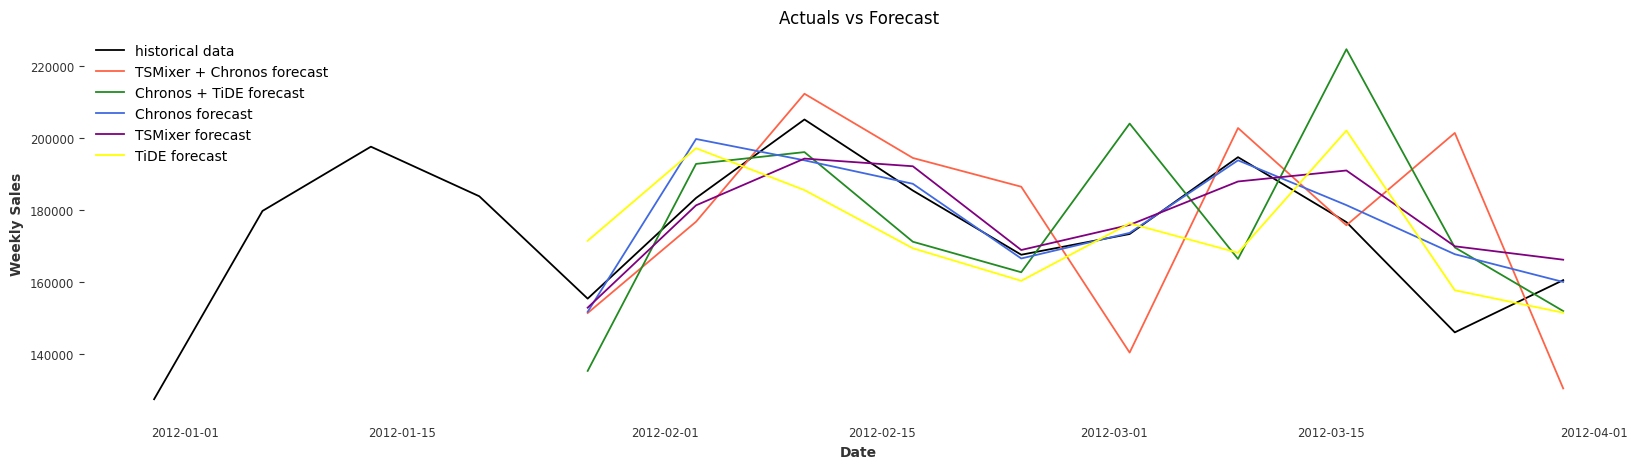

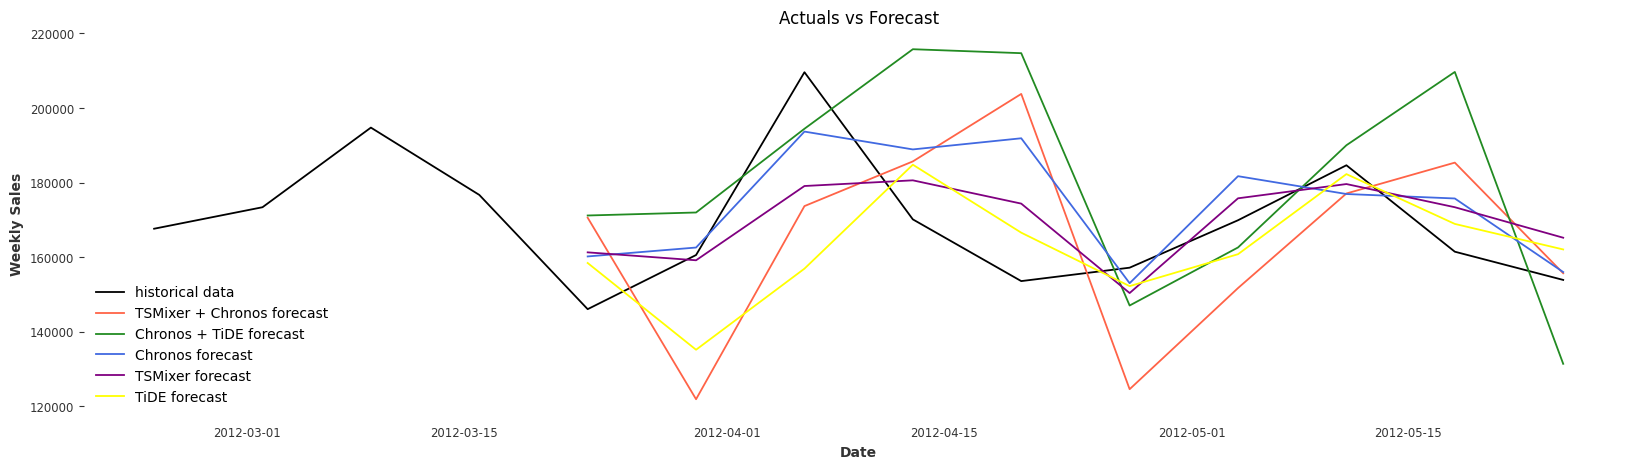

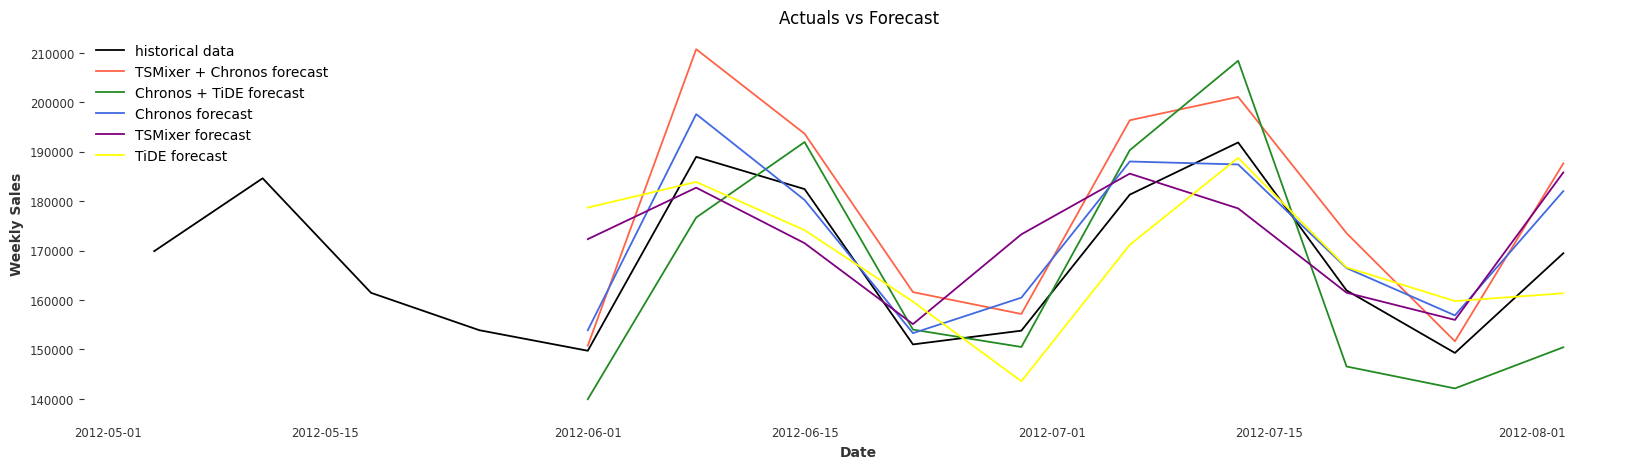

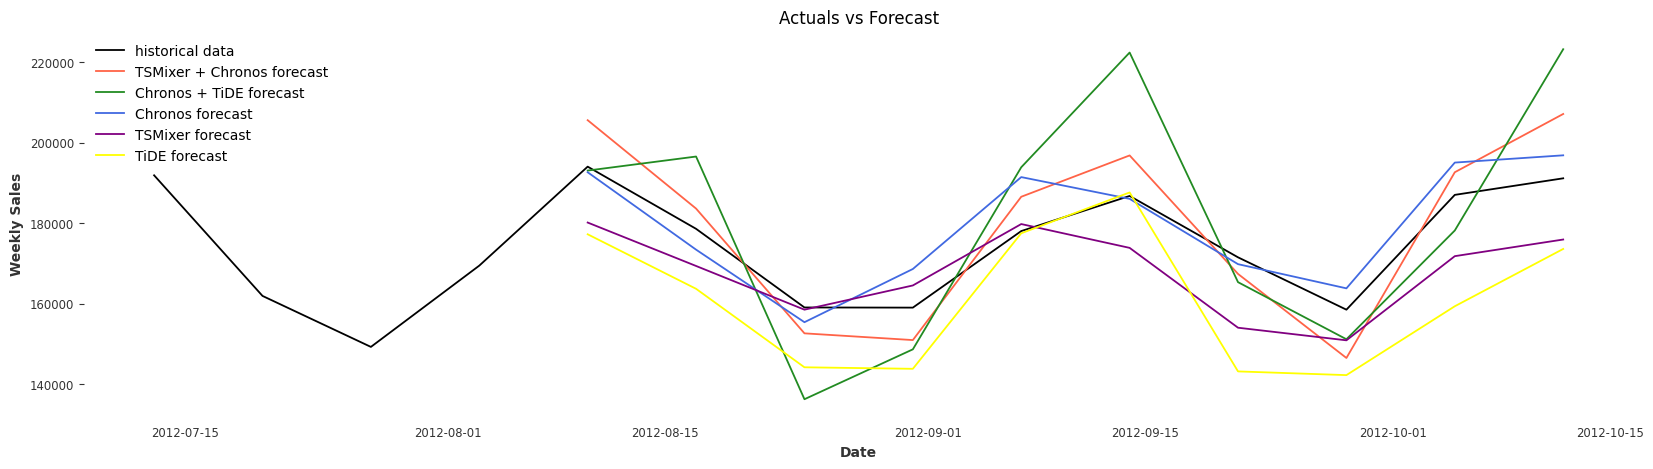

In [ ]:
# get series ordered by volume in a descending way
series = test.groupby('unique_id')[TARGET].sum().reset_index().sort_values(by=TARGET, ascending=False)['unique_id'].tolist()

tests = [test1,test2,test3,test4]

for tide_chronos, tsmixer_chronos, chronos,tsmixer, tide, te in zip(tide_chronos_forecasts,
                                                            tsmixer_chronos_forecasts,
                                                            chronos_forecasts,
                                                            tsmixer_forecast,
                                                            tide_forecast,
                                                            tests):
    for ts in series[:1]:
        forecasts = [(tsmixer_chronos[tsmixer_chronos["unique_id"] == ts],"TSMixer + Chronos"),
                     (tide_chronos[tide_chronos["unique_id"] == ts],"Chronos + TiDE"),
                     (chronos[chronos["unique_id"] == ts],"Chronos"),
                     (tsmixer[tsmixer["unique_id"] == ts],"TSMixer"),
                     (tide[tide["unique_id"] == ts],"TiDE")]

        utils.plot_multiple_forecasts(actuals_data=te[te["unique_id"]==ts],
                                      forecast_data_list=forecasts,
                                      title="Actuals vs Forecast",
                                      y_label="Weekly Sales",
                                      x_label="Date",
                                      forecast_horizon=FORECAST_HORIZON,
                                      interval=False)

## Evaluate forecast

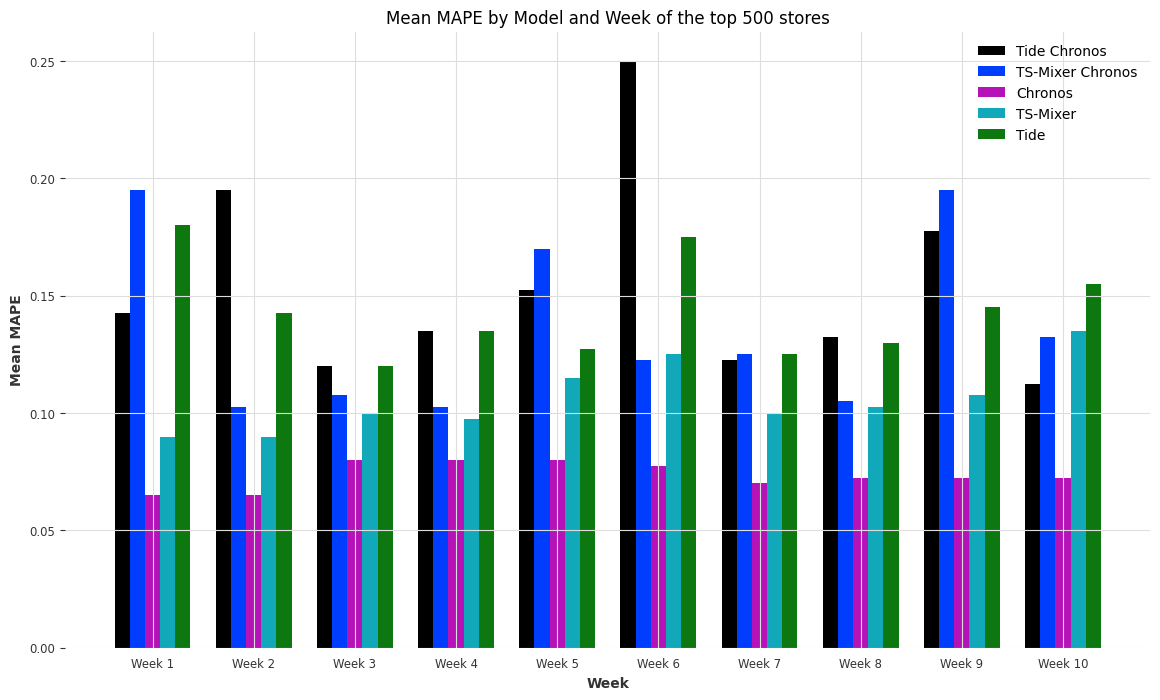

In [27]:
utils.plot_model_comparison([tide_chronos_forecasts,tsmixer_chronos_forecasts,chronos_forecasts,tsmixer_forecast,tide_forecast],tests)

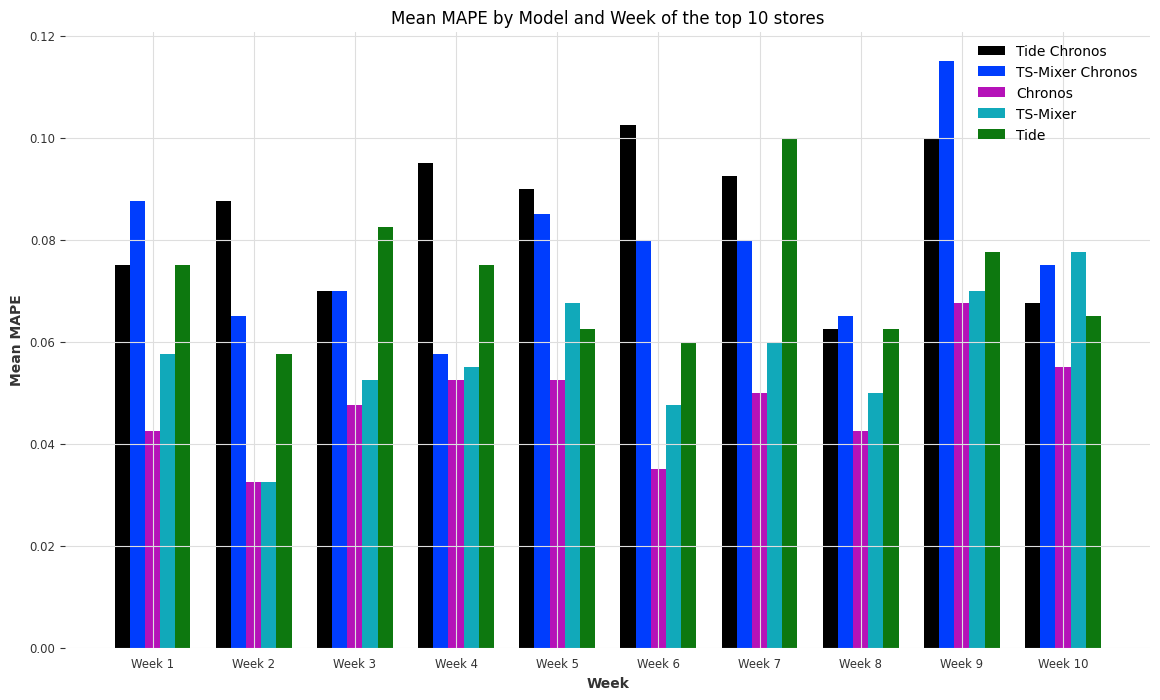

In [33]:
utils.plot_model_comparison([tide_chronos_forecasts,tsmixer_chronos_forecasts,chronos_forecasts,tsmixer_forecast,tide_forecast],tests,top10_stores=top10_stores)